In [36]:
import pandas as pd
import numpy as np
from pathlib import Path
import os



In [37]:
Path.cwd()

PosixPath('/tf/animal_clasificacion')

In [38]:

project_folder = "animal_clasificacion" 
if os.getcwd().endswith("/tf"):
    os.chdir(project_folder)

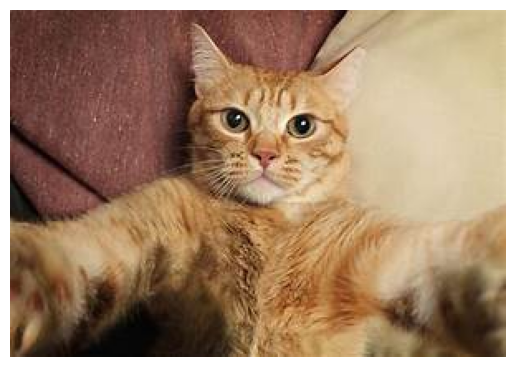

In [39]:
import matplotlib.pyplot as plt
from PIL import Image


# importando la imágen a array

img = Image.open('raw-img/gatto/1.jpeg')


# Representando con matplotlib
def mostrar_imagen(imagen):
    plt.imshow(imagen, cmap='gray')
    plt.axis('off')
    plt.show()
    

mostrar_imagen(img)

In [40]:
BASE_DIR = Path().cwd()

IMG_DIRECTORY = BASE_DIR / 'raw-img'


In [41]:

animales_show = {}

for animal in os.listdir(IMG_DIRECTORY):
    # toma solo la primera imagen encontrada en cada carpeta
    imagenes = list((IMG_DIRECTORY / animal).iterdir())
    if imagenes:
        animales_show[animal] = imagenes[0]

In [42]:
print(animales_show['gatto'])         
print(type(animales_show['gatto']))


/tf/animal_clasificacion/raw-img/gatto/1029.jpeg
<class 'pathlib.PosixPath'>


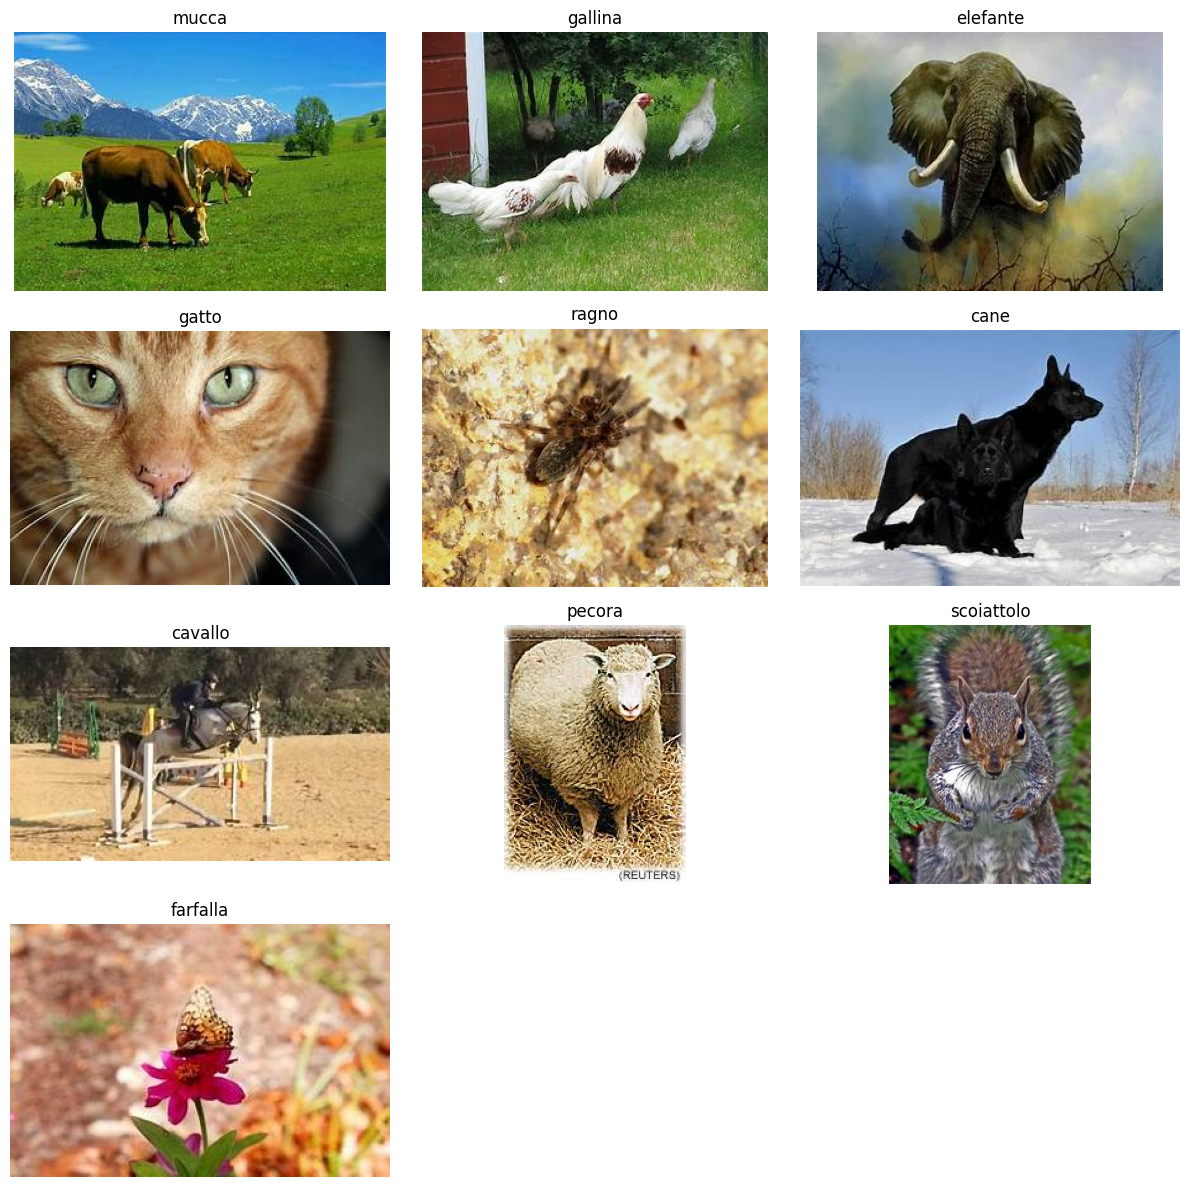

In [43]:
n_animales = len(animales_show)


fig, axes = plt.subplots(4, 3, figsize=(12, 12))  


axes = axes.flatten()

for i, (nombre, ruta) in enumerate(animales_show.items()):
    if i >= 10:
        break  # solo mostramos hasta 10imágenes 1 por cada clase.
    img = Image.open(ruta)
    
    axes[i].imshow(img)
    axes[i].set_title(nombre, fontsize=12)
    axes[i].axis('off')
    
    
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# **PROCESAMIENTO**

In [44]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


data_dir = 'raw-img'

dataset = image_dataset_from_directory(
    data_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    shuffle=True
)

Found 26179 files belonging to 10 classes.


In [45]:
for img, labels in dataset.take(1):
    print("Shape del batch de imágenes:", img.shape)  # (32, 224, 224, 3)
    print("Shape de las etiquetas:", labels.shape)  

Shape del batch de imágenes: (32, 224, 224, 3)
Shape de las etiquetas: (32,)


['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


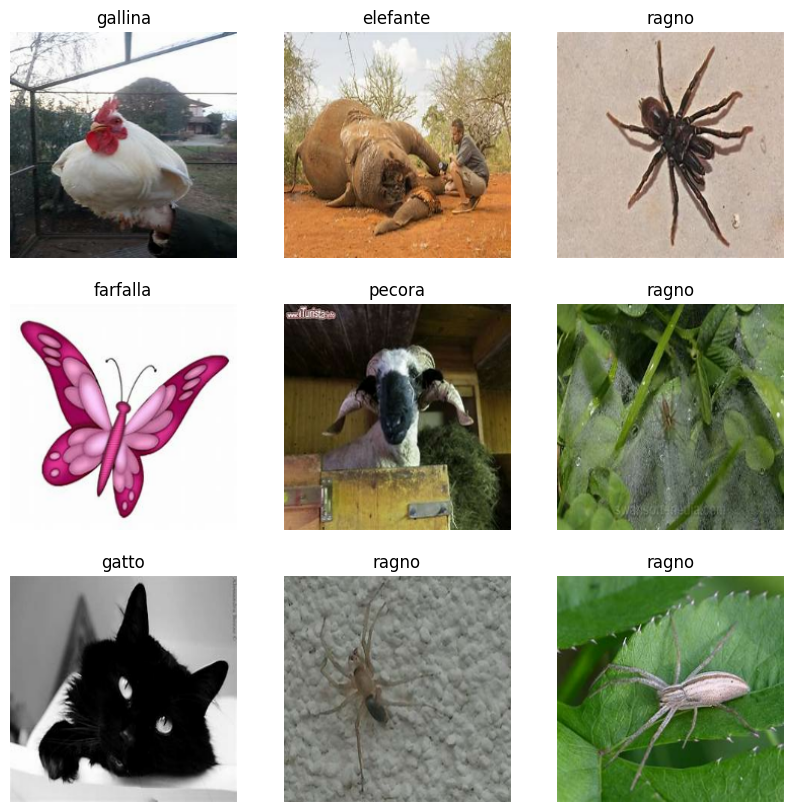

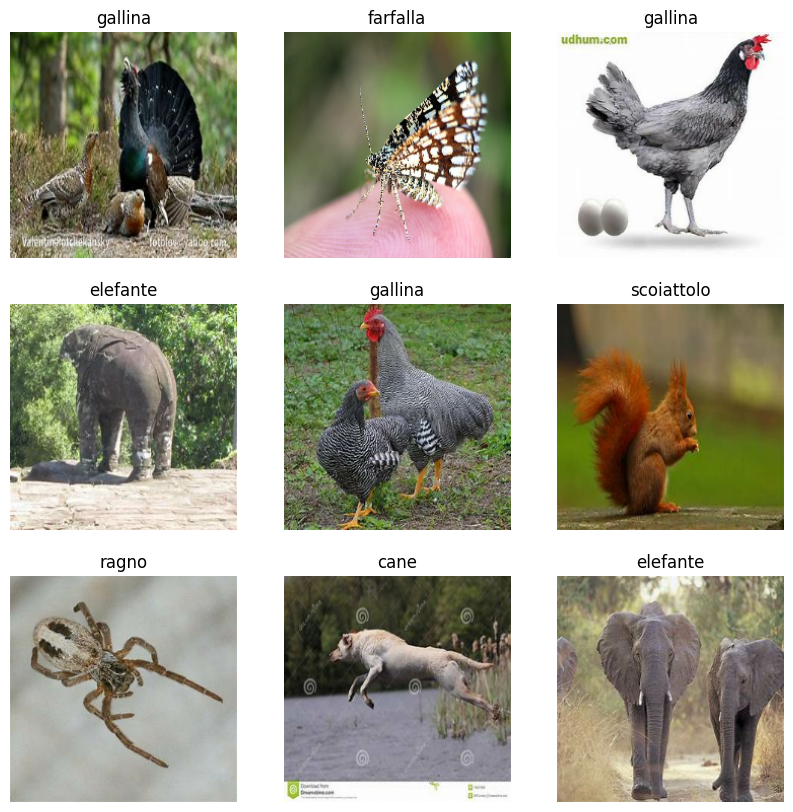

In [46]:


class_names = dataset.class_names

print(class_names)

for img, labels in dataset.take(2):
    
    plt.figure(figsize=(10, 10))
    
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i].numpy()])      # mostrar el nombre de la clase
        plt.axis("off")

In [47]:
from tensorflow.keras.layers import Rescaling


capa_normalizadora = Rescaling(1./255)

# Toma img, label aplicando solo a la imágen la normalizacion y obteniendo la imágen normalizada
normalized_ds = dataset.map(lambda x, y: (capa_normalizadora(x), y))


In [48]:
for imagen, _ in normalized_ds.take(1):
    print("Mínimo:", imagen.numpy().min())
    print("Máximo:", imagen.numpy().max())

Mínimo: 0.0
Máximo: 1.0


# Data Augmentation

In [49]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

Para mejorar el poder predictivo y generalización de los datos y evitar el overfitting se generara una data augmentation con flip horizontal, rotando y además con zoom. La idea es que esto ayde al modelo a aprender de los datos más que a memorizarlos


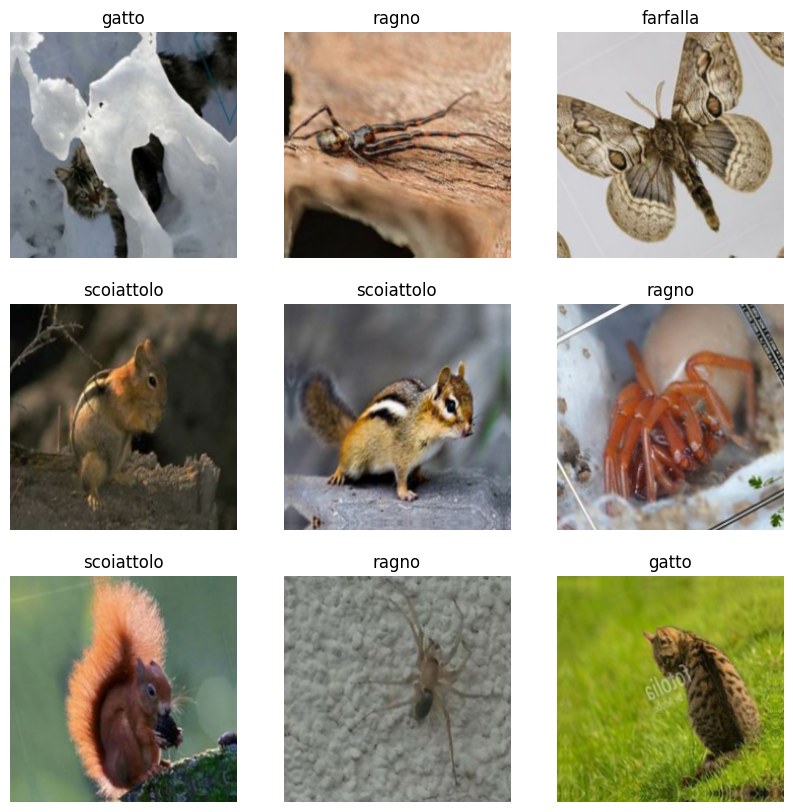

In [50]:
# Mostrar algunas imágenes aumentadas
import matplotlib.pyplot as plt

for images, _ in dataset.take(1):
    augmented_images = data_augmentation(images)
    
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title(class_names[_[i].numpy()])
        plt.axis("off")
    break


In [51]:
final_ds = dataset.map(lambda x, y: (capa_normalizadora(data_augmentation(x)), y))


In [52]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

data_dir = "raw-img"
batch_size = 32
img_size = (224, 224)

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,      # 20% para validación
    subset="training",
    seed=123,                  # semilla para que sea reproducible
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)
class_names = train_ds.class_names
print("Clases:", class_names)



Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.
Clases: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [53]:
from tensorflow.keras.layers import Rescaling
from tensorflow.keras import layers

normalization_layer = Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


# Aplicar aumento y normalización al conjunto de entrenamiento
train_ds = train_ds.map(lambda x, y: (normalization_layer(data_augmentation(x)), y))

# Aplicar solo normalización al conjunto de validación
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


In [54]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Método que ayuda un dataset para mejorar el rendimiento del entrenamiento. Este le dice a tf que cargue los demás batches en segundo plano, asi cuando se termine de entrenar ya se encuentra el otro en memoria. Reduce el tiempo muerto y aumenta el rendimiento general.

AUTOTUNE permite a TensorFlow elegir automáticamente la mejor cantidad de batches para adelantar.

Se aplica después de map() o de cualquier transformación.

In [55]:
import tensorflow as tf
print(tf.__version__)

print(tf.config.list_physical_devices('GPU'))

2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from tensorflow.keras import layers, models
num_classes = len(class_names)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # ayuda a prevenir overfitting
    layers.Dense(num_classes, activation='softmax')
])


model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # porque usamos etiquetas como enteros
    metrics=['accuracy']
)       


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10


2025-06-15 18:21:51.656791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/655 [=>............................] - ETA: 1:16 - loss: 2.2736 - accuracy: 0.1875

2025-06-15 18:21:58.844383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/655 [===>..........................] - ETA: 1:13 - loss: 2.2451 - accuracy: 0.1933

2025-06-15 18:22:03.725585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/655 [=====>........................] - ETA: 1:07 - loss: 2.2339 - accuracy: 0.2016

2025-06-15 18:22:09.478775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/655 [=====>........................] - ETA: 1:05 - loss: 2.2306 - accuracy: 0.2021

2025-06-15 18:22:11.189226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/655 [======>.......................] - ETA: 1:05 - loss: 2.2253 - accuracy: 0.2048

2025-06-15 18:22:12.105177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/655 [=======>......................] - ETA: 1:02 - loss: 2.2156 - accuracy: 0.2057

2025-06-15 18:22:15.462101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/655 [========>.....................] - ETA: 59s - loss: 2.2031 - accuracy: 0.2124

2025-06-15 18:22:18.549256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/655 [==========>...................] - ETA: 52s - loss: 2.1700 - accuracy: 0.2289

2025-06-15 18:22:25.787815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


298/655 [============>.................] - ETA: 46s - loss: 2.1495 - accuracy: 0.2369

2025-06-15 18:22:31.005420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


354/655 [===============>..............] - ETA: 39s - loss: 2.1199 - accuracy: 0.2495

2025-06-15 18:22:38.519907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


440/655 [===================>..........] - ETA: 28s - loss: 2.0727 - accuracy: 0.2692

2025-06-15 18:22:49.680132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


487/655 [=====================>........] - ETA: 22s - loss: 2.0506 - accuracy: 0.2779

2025-06-15 18:22:55.903512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


490/655 [=====================>........] - ETA: 21s - loss: 2.0494 - accuracy: 0.2784

2025-06-15 18:22:56.324432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


504/655 [======================>.......] - ETA: 19s - loss: 2.0415 - accuracy: 0.2818

2025-06-15 18:22:58.270698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


520/655 [======================>.......] - ETA: 17s - loss: 2.0373 - accuracy: 0.2833

2025-06-15 18:23:00.356728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


557/655 [========================>.....] - ETA: 12s - loss: 2.0226 - accuracy: 0.2880

2025-06-15 18:23:05.221781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


606/655 [==========================>...] - ETA: 6s - loss: 2.0039 - accuracy: 0.2950

2025-06-15 18:23:11.646749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


655/655 [==============================] - ETA: 0s - loss: 1.9888 - accuracy: 0.3004

2025-06-15 18:23:18.354820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:23:18.496691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:23:18.708464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-06-15 18:23:20.337506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


655/655 [==============================] - 90s 136ms/step - loss: 1.9888 - accuracy: 0.3004 - val_loss: 1.8751 - val_accuracy: 0.3578
Epoch 2/10


2025-06-15 18:23:21.297683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/655 [>.............................] - ETA: 1:26 - loss: 1.7910 - accuracy: 0.3653

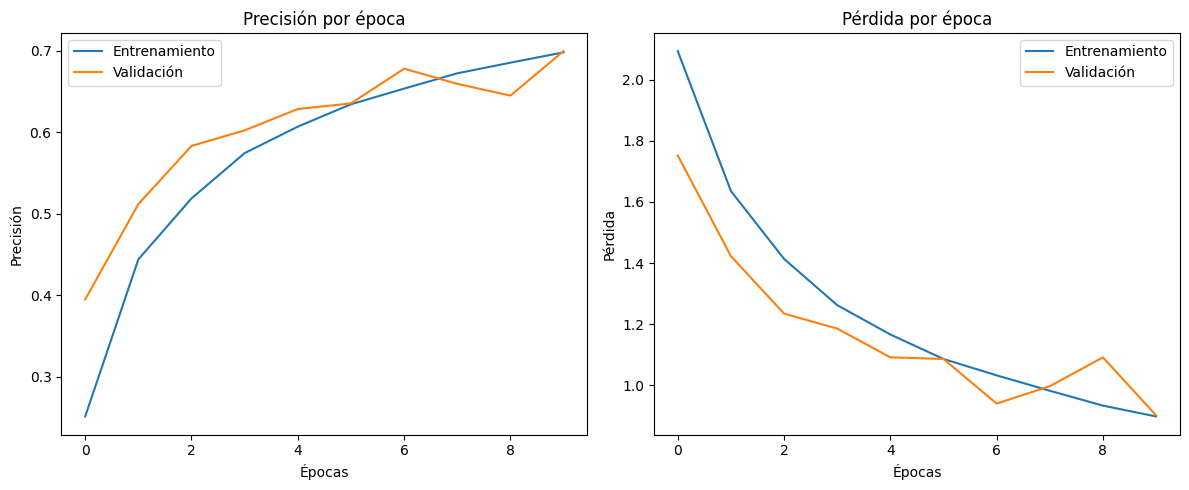

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.title('Precisión por época')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.title('Pérdida por época')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()


plt.tight_layout()
plt.show()



In [ ]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congela las capas pre-entrenadas

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

9406464/9406464 [==============================] - 1s 0us/step
